In [2]:
import torch
import pickle
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import SparsePCA, PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram

In [3]:
def get_line_name(df, cell_id):
    return df[df["specimen__id"] == cell_id]["line_name"].to_numpy()[0]

def get_labels(cell_ids):
    df = pd.read_csv("data/metadata.csv")
    line_names = ["Pvalb", "Sst", "Vip", "Htr3a", "Ndnf", "Cux2", "Nr5a1", "Ntsr1", "Rorb", "Scnn1a", "Tlx3"]
    new_cell_ids = []
    labels = []
    
    for cell_id in cell_ids:
        line_name = get_line_name(df, cell_id)
        if type(line_name) != str or "|" in line_name:
            pass
        elif line_name.split("-")[0] in line_names:
            new_cell_ids.append(cell_id)
            labels.append(line_name.split("-")[0])
    
    types, counts = np.unique(labels, return_counts=True)
    types = types[counts > 10]
    new_cell_ids, labels = zip(*list(filter(lambda x: x[1] in types, zip(new_cell_ids, labels))))
    
    return np.array(new_cell_ids), np.array(labels)

def get_dataset():
    with open("data/dataset.pickle", "rb") as f:
        dataset = pickle.load(f)
    cell_ids, ys = get_labels(dataset.keys())
    xs = np.array([dataset[cell_id][0].tolist() for cell_id in cell_ids])
    return xs, ys, cell_ids

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def plot_cluster(xs, ys, y=-0.5, n_neighbors=5, min_dist=0.5):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    #reducer = PCA(n_components=2)
    X = reducer.fit_transform(xs)
    
    types = sorted(np.unique(ys))
    n_types = len(types)
    
    colors = {}
    cm = plt.get_cmap('gist_rainbow')
    for i, t in enumerate(types):
        colors[t] = np.array(list(cm(1. * i / n_types))).reshape(1, -1)

    for t in types:
        plt.scatter(X[ys == t,0], X[ys == t, 1], alpha=0.3, label=t, s=10, c=colors[t])
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, y),
              ncol=5, fancybox=True, shadow=True)
    plt.title(f"UMAP plot of EKFR parameters\nbin_size=20, activation_bin_size=20, n_kernels=5")
    plt.xlabel("$UMAP_0$")
    plt.ylabel("$UMAP_1$");

In [87]:
xs, ys, cell_ids = get_dataset()
xs = xs[:, :10]
xs_scaled = StandardScaler().fit_transform(xs)

types, counts = np.unique(ys, return_counts=True)
types = ["Htr3a", "Ndnf", "Vip", "Sst", "Pvalb", "Cux2", "Nr5a1", "Scnn1a", "Rorb", "Ntsr1"]
mapping = {t: i for i, t in enumerate(types)}
inv_mapping = {i: t for i, t in enumerate(types)}

pca = PCA(n_components=5)
xs_pca = pca.fit_transform(xs)

clustering = AgglomerativeClustering(n_clusters=len(types), compute_distances=True, metric="euclidean", linkage="ward")
clustering.fit(xs_scaled);

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([165,  24,  62,  36,  40, 100,  28,  20, 116,  59]))


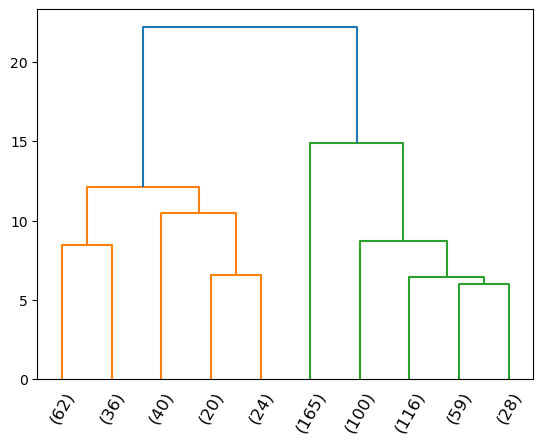

In [84]:
plot_dendrogram(clustering, truncate_mode="lastp", p=10, leaf_rotation=60.,
            leaf_font_size=12.)
print(np.unique(clustering.labels_, return_counts=True))

In [88]:
mat = np.zeros((len(types), len(types)))
for i, y in zip(clustering.labels_, ys):
    mat[mapping[y],i] += 1
idx_map = [(j, i) for i, j in enumerate(sorted(range(10), key=lambda i: mat[i, :] @ np.linspace(-1, 1, 10)))]

In [77]:
perm = np.zeros((len(types), len(types)))
for i, j in idx_map:
    perm[j, i] = 1
    
mat = perm @ mat

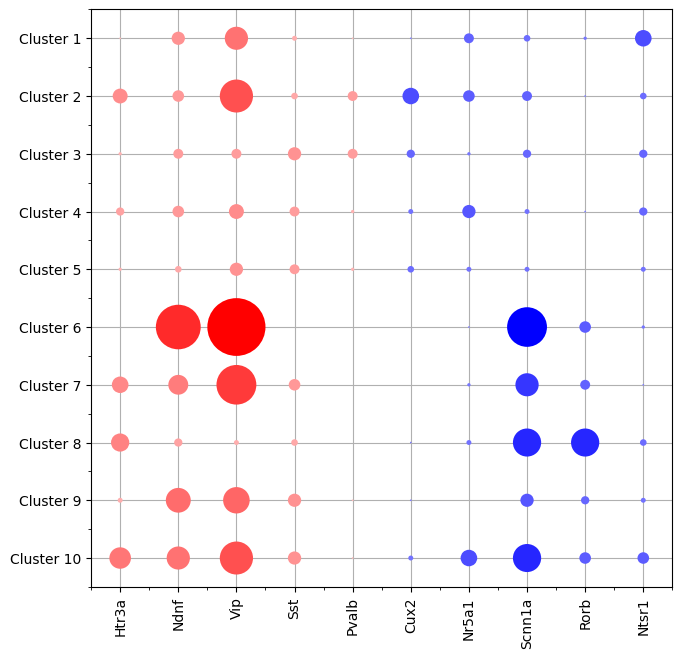

In [89]:
from matplotlib.collections import PatchCollection

N, M = mat.shape
ylabels = [f"Cluster {i+1}" for i in range(len(types))][::-1]
xlabels = [f"{inv_mapping[i]}" for i in range(len(types))]

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = mat
c = np.zeros((N, M))
norm = s/s.max()
c[:, :5] = 1 + norm[:,:5] * 2
c[:, 5:] = -1 - norm[:,5:] * 2

fig, ax = plt.subplots(figsize=(7.5, 7.5), dpi=100)

R = s/s.max()/2
circles = [plt.Circle((j, i), radius=r, color='k', linewidth=10) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")
ax.add_collection(col)

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid()
ax.set_axisbelow(True)
plt.xticks(rotation=90)
#fig.colorbar(col)
plt.show()

In [ ]:
import sklearn

for metric in ["l1", "euclidean", "cosine"]:
    for linkage in ["ward", "complete", "average", "single"]:
        if linkage == "ward" and metric != "euclidean":
            pass
        else:
            for x in ["xs", "xs_scaled", "xs_pca"]:
                if x == "xs":
                    a = xs
                elif x == "xs_scaled":
                    a = xs_scaled
                else:
                    a = xs_pca
            print(metric, linkage, x)
            clustering = AgglomerativeClustering(n_clusters=len(types), compute_distances=True, metric=metric, linkage=linkage)
            clustering.fit(a);
            #print(sklearn.metrics.v_measure_score(ys, clustering.labels_))
            print(sklearn.metrics.adjusted_rand_score(ys, clustering.labels_))

Dont include:
Gad2
Slc17
Vertical line

Merge labels with same first part

Exclude cells without many samples

Focus:
Inhibitory:
Pvalb
Sst
Vip subset of Htr3a
Ndnf

Excitatory:
Cux2
Nr5a1
Ntsr1
Rorb
Scnn1a
Tlx3

UMAP for visualization only
Cluster (Ward) in PCA or parameter space

In [90]:
inhibitory = ["Pvalb", "Sst", "Vip", "Htr3a", "Ndnf"]

In [91]:
import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_confusion_matrix

def summary(model, dataloader, n_classes):
    y_pred, y = get_predictions(model, dataloader, n_classes)
    f = multiclass_f1_score(y_pred, y, num_classes=n_classes, average="weighted")
    acc = multiclass_accuracy(y_pred, y, num_classes=n_classes)
    return f, acc

def get_predictions(model, dataloader, n_classes):
    ys, ys_pred = [], []
    with torch.no_grad():
        for X, y, w in dataloader:
            X = X.to(torch.float32)
            y1 = torch.einsum("ij,j->i", y, torch.arange(n_classes))
            y = y.to(torch.float32)
            ys_pred.append(model(X))
            ys.append(y1)
    return torch.cat(ys_pred), torch.cat(ys)

class ParameterDataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys, label_map):
        self.n_classes = len(label_map)
        self.xs = list(map(torch.tensor, xs))
        self.ys = list(map(torch.tensor, [label_map[y] for y in ys]))
        self.ys = list(map(lambda x: F.one_hot(x, num_classes=self.n_classes), self.ys))
        
        types, counts = np.unique(ys, return_counts=True)
        ws = (1 / counts) / np.sum(1 / counts)
        w_map = {t: w for t, w in zip(types, ws)}
        self.ws = list(map(lambda x: w_map[x], ys))

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx], self.ws[idx]

from sklearn.model_selection import train_test_split

def train_model(xs, ys, pca=True, scale=True, linear=False):
    types = np.unique(ys).tolist()
    label_map = {t: i for i, t in enumerate(types)}
    n_classes = len(label_map)

    z = list(zip(xs, ys, cell_ids))
    ztr, zte = train_test_split(z, test_size=0.35, stratify=ys)
    Xtr, ytr, cell_ids_tr = zip(*ztr)
    Xte, yte, cell_ids_te = zip(*zte)
    z = list(zip(Xtr, ytr, cell_ids_tr))
    ztr, zval = train_test_split(z, test_size=0.15, stratify=ytr)
    Xtr, ytr, cell_ids_tr = zip(*ztr)
    Xval, yval, cell_ids_val = zip(*zval)
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xval = scaler.transform(Xval)
        Xte = scaler.transform(Xte)
        xs = scaler.transform(xs)
    
    if pca:
        scaler = PCA(n_components=5)
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xval = scaler.transform(Xval)
        Xte = scaler.transform(Xte)
        xs = scaler.transform(xs)

    train_dataset = ParameterDataset(Xtr, ytr, label_map)
    val_dataset = ParameterDataset(Xval, yval, label_map)
    test_dataset = ParameterDataset(Xte, yte, label_map)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(yte), shuffle=False)
    
    if linear:
        model = torch.nn.Sequential(
            torch.nn.Linear(len(xs[0]), n_classes)
        )
    else:
        model = torch.nn.Sequential(
            torch.nn.Linear(len(xs[0]), 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, n_classes)
        )

    types, counts = np.unique(ys, return_counts=True)
    ws = torch.tensor((1 / counts) / np.sum(1 / counts))

    criterion = torch.nn.CrossEntropyLoss(weight=ws)
    optim = torch.optim.Adam(model.parameters(), lr=0.005)
    epochs = 500

    train_accs = []
    train_f1s = []
    val_accs = []
    val_f1s = []

    for epoch in range(epochs):
        loss = 0
        for X, y, w in train_loader:
            X = X.to(torch.float32)
            y = y.to(torch.float32)
            y_pred = model(X)
            loss += criterion(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        f_tr, acc_tr = summary(model, train_loader, n_classes)
        f_val, acc_val = summary(model, val_loader, n_classes)
        train_accs.append(acc_tr.item())
        train_f1s.append(f_tr.item())
        val_accs.append(acc_val.item())
        val_f1s.append(f_val.item())

        if (epoch + 1) % 10000 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item()}")

    #print_summary(model, train_loader, n_classes)
    f, acc = summary(model, test_loader, n_classes)

    if False:
        ts = list(range(len(train_accs)))
        
        plt.figure()
        plt.plot(ts, train_accs, label="train")
        plt.plot(ts, val_accs, label="val")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")

        plt.figure()
        plt.plot(ts, train_f1s, label="train")
        plt.plot(ts, val_f1s, label="val")
        plt.ylabel("f1 score");
        
    return f.item(), acc.item()

In [92]:
for scale in [True, False]:
    for pca in [True, False]:
        for binary in [True, False]:
            for linear in [True, False]:
                print(f"{linear=}, {binary=}, {pca=}, {scale=}")
                for p in ["activation", "kernel", "all"]:
                    xs, ys, cell_ids = get_dataset()
                    if p == "activation":
                        xs = [x[10:] for x in xs]
                    if p == "kernel":
                        xs = [x[:10] for x in xs]
                        
                    if binary:
                        ys = ["inhibitory" if y in inhibitory else "excitatory" for y in ys]

                    fs = []
                    accs = []
                    for _ in range(10):
                        f, acc = train_model(xs, ys, pca=pca, scale=scale, linear=linear)
                        fs.append(f)
                        accs.append(acc)
                    
                    print(f"({p}) f1 score: mean {np.mean(fs):.4f}, std {np.std(fs):.4f}")
                    print(f"({p}) accuracy: mean {np.mean(accs):.4f}, std {np.std(accs):.4f}")
                print("------------------------")

linear=True, binary=True, pca=True, scale=True


ValueError: Found array with 0 feature(s) (shape=(358, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
def get_latent_variables(xs):
    zs = []
    for x in xs:
        with torch.no_grad():
            z = model[:-1](torch.tensor(x).to(torch.float32))
        zs.append(z.tolist())
    zs = np.array(zs)
    #zs = StandardScaler().fit_transform(zs)
    return zs

zs = get_latent_variables(xs)

for n_neighbors in (3, 5, 10, 20, 50):
    for min_dist in (0.15, 0.25, 0.5, 0.8, 1.0):
        print(n_neighbors, min_dist)
        plt.figure()
        plot_cluster(zs, np.array(ys), y=-0.3, n_neighbors=n_neighbors, min_dist=min_dist)
        plt.show()

In [ ]:
np.unique(ys, return_counts=True)

In [ ]:
for n_neighbors in (3, 5, 10, 20, 50):
    for min_dist in (0.15, 0.25, 0.5, 0.8, 1.0):
        print(n_neighbors, min_dist)
        plt.figure()
        plot_cluster(xs_pca, np.array(ys), y=-0.3, n_neighbors=n_neighbors, min_dist=min_dist)
        plt.show()